#### <font color = 'grey'> Imports </font>

In [135]:
import numpy as np
import seaborn as sbn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

### ML

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RandomizedSearchCV

#### <font color = 'green'> Load Dataset </font>

In [3]:
df = sbn.load_dataset('tips')
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### <font color = 'red'> Exploratory Data Analysis </font>

In [41]:
print('Shape of the dataframe is : ', df.shape, '\n','Therefore it has ', df.shape[0], 'rows and ', df.shape[1], ' columns', '\n')
df.info()


Shape of the dataframe is :  (244, 7) 
 Therefore it has  244 rows and  7  columns 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   total_bill  244 non-null    float64 
 1   tip         244 non-null    float64 
 2   sex         244 non-null    category
 3   smoker      244 non-null    category
 4   day         244 non-null    category
 5   time        244 non-null    int64   
 6   size        244 non-null    int64   
dtypes: category(3), float64(2), int64(2)
memory usage: 8.9 KB


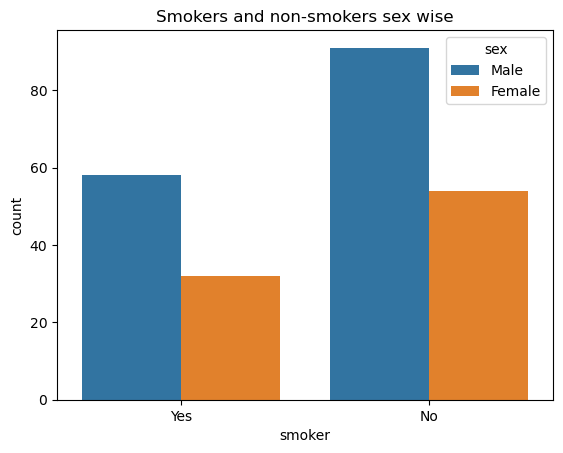

In [84]:
grouped = df.groupby(['sex', 'smoker']).size().reset_index(name = 'count')
sbn.barplot(data = grouped, x = 'smoker', y = 'count', hue = 'sex')
plt.title('Smokers and non-smokers sex wise');

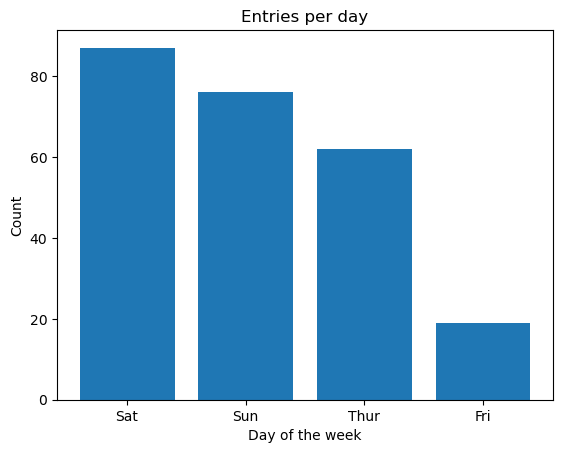

In [42]:
days = df['day'].value_counts()

days_cat = days.index
counts = days.values

plt.bar(days_cat, counts)
plt.title('Entries per day')
plt.xlabel('Day of the week')
plt.ylabel('Count')
plt.show();

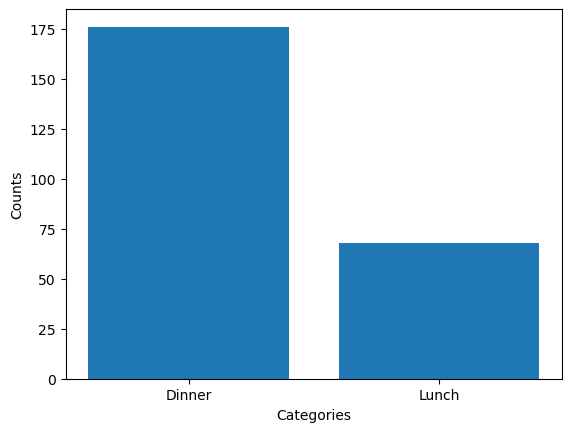

In [32]:
def plot_bar(lista):
    big = lista.value_counts()
    categories = big.index
    counts = big.values
    
    plt.bar(categories, counts)
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    
    plt.show()
plot_bar(df['time'])


In [33]:
encoder = LabelEncoder()
df['time'] = encoder.fit_transform(df['time'])

In [35]:
df['time'].value_counts()

0    176
1     68
Name: time, dtype: int64

<AxesSubplot: xlabel='tip'>

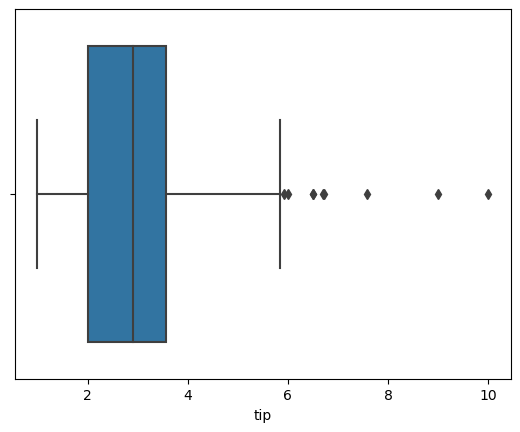

In [49]:
### cheking outliers 

sbn.boxplot(x = df['tip'])

In [59]:
median = df['tip'].median()
df.loc[df['tip']>10, 'tip'] = median


In [60]:
Q1 = df['tip'].quantile(.25)
Q3 = df['tip'].quantile(.75)
IQR = Q3 - Q1 


In [63]:
df = df[(df['tip'] > Q1 - 1.5*IQR) & (df['tip'] < Q3 + 1.5 * IQR)]
df.shape

(235, 7)

In [70]:
X = df.drop(labels = ['time'], axis = 1)
Y = df['time']

In [88]:
corelationes = df.corr(numeric_only = True)
corelationes

,total_bill,tip,time,size
total_bill,1.000000,0.595065,-0.171044,0.581462
tip,0.595065,1.000000,-0.096621,0.450306
time,-0.171044,-0.096621,1.000000,-0.111101
size,0.581462,0.450306,-0.111101,1.000000


#### <font color = 'grey'> Training ML Models </font>

In [116]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = .25, random_state = 42)

In [117]:
x_train

,total_bill,tip,sex,smoker,day,size
107,25.21,4.29,Male,Yes,Sat,2
177,14.48,2.00,Male,Yes,Sun,2
176,17.89,2.00,Male,Yes,Sun,2
114,25.71,4.00,Female,No,Sun,3
230,24.01,2.00,Male,Yes,Sat,4
...,...,...,...,...,...,...
109,14.31,4.00,Female,Yes,Sat,2
14,14.83,3.02,Female,No,Sun,2
95,40.17,4.73,Male,Yes,Fri,4
185,20.69,5.00,Male,No,Sun,5


In [118]:
numerical_cols = ['total_bill', 'tip', 'size']
categorical_cols = ['sex', 'smoker', 'day']

##### <font color = 'green' > Feature Engineering Automation </font>

In [119]:
numerical_pipeline = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'mean')), 
        ('scaler', StandardScaler())])

categorical_pipeline = Pipeline(
    steps = [
        ('imputer', SimpleImputer(strategy = 'most_frequent')), 
        ('onehotencoder', OneHotEncoder())])

preprocessor = ColumnTransformer([
    ('numerical_pipeline', numerical_pipeline, numerical_cols), 
    ('categorical_pipeline', categorical_pipeline, categorical_cols)
])

In [120]:
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

In [123]:
models = {
    'RandomForestClassifier' : RandomForestClassifier(), 
    'DecisionTreeClassifier' : DecisionTreeClassifier(), 
    'SVC' : SVC()
}

In [138]:
def evaluate_model(x_train, x_test, y_train, y_test):
    report = {}
    
    for i in range(len(models)):
        model = list(models.values())[i]
        
        model.fit(x_train, y_train)
        
        y_pred = model.predict(x_test)
        
        model_score = accuracy_score(y_test, y_pred)
        
        report[list(models.keys())[i]] = model_score
        
    return report

In [139]:
report = evaluate_model(x_train, x_test, y_train, y_test)

In [143]:
rfc = RandomForestClassifier()

In [144]:
rfc_params = { 'max_depth': [3, 5, 10, 20, None], 
              'n_estimators': [100, 200, 300], 
              'criterion': ['gini', 'entropy']}

In [150]:
cf = RandomizedSearchCV(rfc, param_distributions = rfc_params, scoring = 'accuracy', verbose = 2)
cf.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ..criterion=entropy, max_depth=20, n_estimators=200; total time=   0.2s
[CV] END ..criterion=entropy, max_depth=20, n_estimators=200; total time=   0.1s
[CV] END ..criterion=entropy, max_depth=20, n_estimators=200; total time=   0.1s
[CV] END ..criterion=entropy, max_depth=20, n_estimators=200; total time=   0.1s
[CV] END ..criterion=entropy, max_depth=20, n_estimators=200; total time=   0.1s
[CV] END .....criterion=gini, max_depth=10, n_estimators=200; total time=   0.1s
[CV] END .....criterion=gini, max_depth=10, n_estimators=200; total time=   0.1s
[CV] END .....criterion=gini, max_depth=10, n_estimators=200; total time=   0.1s
[CV] END .....criterion=gini, max_depth=10, n_estimators=200; total time=   0.1s
[CV] END .....criterion=gini, max_depth=10, n_estimators=200; total time=   0.1s
[CV] END ......criterion=gini, max_depth=5, n_estimators=200; total time=   0.1s
[CV] END ......criterion=gini, max_depth=5, n_es

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, 20, None],
                                        'n_estimators': [100, 200, 300]},
                   scoring='accuracy', verbose=2)

In [151]:
cf.best_params_

{'n_estimators': 100, 'max_depth': 3, 'criterion': 'entropy'}

In [152]:
ypred = cf.predict(x_test)

accuracy = accuracy_score(y_test, ypred)
accuracy

1.0

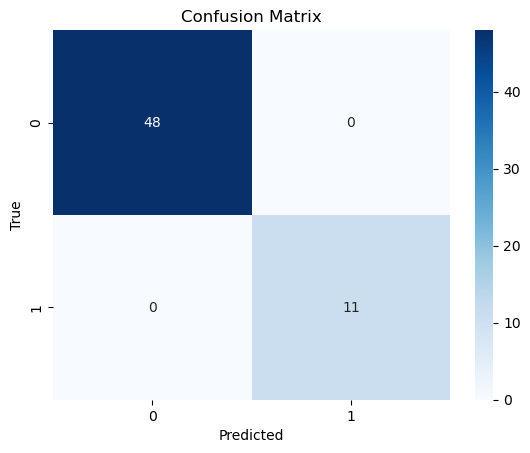

In [154]:
cm = confusion_matrix(y_test, ypred)

sbn.heatmap(cm, annot = True, cmap = 'Blues', fmt = 'g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show();